<a href="https://colab.research.google.com/github/liavaldetaro/RadarDataset/blob/main/RadarDataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Radar dataset**

In this notebook, we will explore a radar dataset from Kaggle: https://www.kaggle.com/datasets/iroldan/real-doppler-raddar-database


> The radar used to capture the data is a ubiquitous or persistent radar system developed by the Microwave and Radar Group from the UPM called RAD-DAR (Digital Array Receiver). The radar uses a frequency-modulated continuous wave (FMCW) on a frequency band centered at 8.75 GHz with a maximum bandwidth of 500 MHz.

The data contains **labelled** video radar data from cars, people and drones. Let's try to see if we can classify it!



In [36]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections.abc import Iterator
import tensorflow as tf
from keras.callbacks import EarlyStopping
import kagglehub

In [3]:

# Let's start by downloading the dataset into our notebook:
path = kagglehub.dataset_download("iroldan/real-doppler-raddar-database")

# Let's print the path to where the data is saved to:
print("Path to dataset files:", path)

100%|██████████| 63.6M/63.6M [00:00<00:00, 247MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/iroldan/real-doppler-raddar-database/versions/2


## **Data analysis**

Perfect! Our data is loaded into the .cache folder. Let's start by taking a look at what the data looks like.

In [17]:
# Let's see what is in our dataset

print(os.listdir(path))   # listing the subdirectories
print(os.listdir(path + '/data/Cars/15-42'))

['Cars', 'People', 'Drones', 'data']
['159.csv', '145.csv', '014.csv', '161.csv', '114.csv', '117.csv', '177.csv', '024.csv', '127.csv', '008.csv', '031.csv', '172.csv', '079.csv', '148.csv', '053.csv', '022.csv', '166.csv', '185.csv', '151.csv', '162.csv', '057.csv', '110.csv', '062.csv', '030.csv', '153.csv', '064.csv', '167.csv', '065.csv', '135.csv', '126.csv', '072.csv', '131.csv', '140.csv', '012.csv', '134.csv', '103.csv', '099.csv', '035.csv', '094.csv', '184.csv', '119.csv', '092.csv', '154.csv', '138.csv', '011.csv', '082.csv', '130.csv', '123.csv', '168.csv', '112.csv', '096.csv', '163.csv', '105.csv', '088.csv', '152.csv', '029.csv', '021.csv', '002.csv', '005.csv', '136.csv', '048.csv', '017.csv', '104.csv', '070.csv', '142.csv', '038.csv', '078.csv', '118.csv', '086.csv', '125.csv', '128.csv', '068.csv', '087.csv', '001.csv', '150.csv', '077.csv', '007.csv', '003.csv', '052.csv', '066.csv', '054.csv', '013.csv', '028.csv', '097.csv', '033.csv', '178.csv', '063.csv', '141.

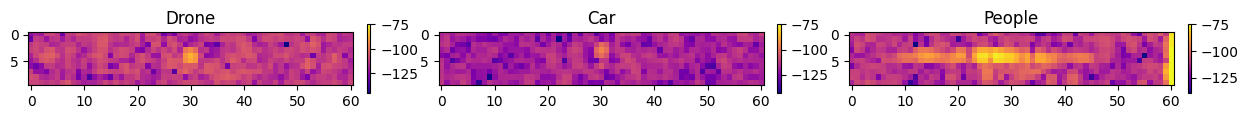

In [34]:
# Let's open an image from each dataset

drone_image = pd.read_csv(
    path + "/Drones/15-42/159.csv"
)

car_image = pd.read_csv(
    path + "/Cars/15-42/159.csv"
)

people_image = pd.read_csv(
    path + "/People/16-06/014.csv"
)


# We can now plot the images
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
plt1 = ax[0].imshow(drone_image, cmap='plasma', vmax=-75)
plt2 = ax[1].imshow(car_image, cmap='plasma', vmax=-75)
plt3 = ax[2].imshow(people_image, cmap='plasma', vmax=-75)
ax[0].set_title("Drone")
ax[1].set_title("Car")
ax[2].set_title("People")
plt.colorbar(plt1, ax=ax[0], fraction=0.01, pad=0.04)
plt.colorbar(plt2, ax=ax[1], fraction=0.01, pad=0.04)
plt.colorbar(plt3, ax=ax[2], fraction=0.01, pad=0.04)
plt.show()


The images don't really look that different to the human eye - let's hope our model can do a better job at classifying them :)

Now that we are a bit more familiar with the data, we can start **preparing it** to feed into our AI model.
There are a couple of steps to this preparation:

1.  Load in the images and corresponding labels (if it is a car, a drone or a person)
2.  Normalize our data - meaning that we change the values so that all of the pixels are between 0 and 1 - this makes it easier for our AI model.
3. Split our data into a training set (which we give to the model) and a test set (which the model doesn't get to see - we use this set to test how good our model is).


To keep our code organized, let's put these functionalities into **python functions**. Don't worry too much about this part of the code - the fun AI training comes later :)



In [46]:
labels = {"Cars": 0, "Drones": 1, "People": 2}


def load_category_frames(folder_path):
  """Load all CSVs from a folder in order."""
  frames = []
  files = sorted(
      [f for f in os.listdir(folder_path) if f.endswith(".csv")],
      key=lambda x: int(x.split('_')[-1].split('.')[0])  # e.g., "sample_001.csv"
  )
  for file in files:
      file_path = os.path.join(folder_path, file)
      df = pd.read_csv(file_path, header=None).values
      frames.append(df)
  return frames


def data_preparation(
    dataset_path:str, categories: dict, test_size: float, random_seed: int
    ) -> None:# tuple[tf.data.Dataset, tf.data.Dataset, tf.data.Dataset, tf.data.Dataset]:
    """Crawls through our data folder, normalizes all images and returns our
    split dataset."""

    # Crawl through the source directory
    for root, dirs, files in os.walk(dataset_path):
      print(dirs, files)

